<a href="https://colab.research.google.com/github/fatehOurghi/face-detection-evaluation/blob/main/notebook_FD_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of face detection algorithms

This colab notebook will be used to evaluate different face detection algorithms including:
1.   TinaFace (best of Wider Face)
2.   DSFD (best of FDDB)
3.   SRN (best of Pascal Face)
---
Datasets used in this evaluation are:
*   Wider Face
*   FDDB
*   Pascal Face

**Machine configurations**

In [1]:
!nvidia-smi

Sun Mar 14 22:58:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7CNj_MdXxs3GtbbQfVGuNPyMFferShfc96jQwGt9xsABppgzt_HEI


# Datasets Preparation

**Extract downloaded *Wider face* dataset**

In [ ]:
# Extract train data
import zipfile
dataset_path = "/content/drive/MyDrive/Datasets/FaceDetection/WiderFace/WIDER_train.zip"
unzip_to = "/content/drive/MyDrive/Datasets/WIDER_train"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_to)

In [ ]:
# Extract test data
import zipfile
dataset_path = "/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/WIDER_test.zip"
unzip_to = "/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_to)

In [ ]:
# Download dataset face annotations
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip

In [ ]:
# extract annotations
!unzip -q /content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/wider_face_split.zip

**Download of FDDB dataset**

In [ ]:
!wget http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz

In [ ]:
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz

**Extract FDDB dataset**




In [ ]:
# extract dataset
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/PascalFace/caltech.tar.gz

In [ ]:
# extract annotations
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/FDDB/FDDB-folds.tgz

**Extract FDDB dataset**

In [ ]:
!tar -zxvf /content/drive/MyDrive/Datasets/FaceDetection/FDDB/originalPics.tar.gz

**Download the Pascal Face dataset**

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/download/caltech.tar.gz

# Load dataset

In [2]:
import cv2
from google.colab.patches import cv2_imshow

In [2]:
ROOT = '/content/drive/MyDrive/Datasets/FaceDetection/'
import os
import json
#default: load rectangles list
def load_annotations(path, atype='rectangle'):
  filenames = []
  annotations = []
  for filename in os.listdir(path):
    if filename.__contains__(atype):
      filenames.append(filename)
  for filename in filenames:
    raw = open(path + filename)
    doc = {
        'annotations_filename': filename,
        'annotations': json.loads(raw.read())
    }
    annotations.append(doc)
    
  return annotations



**Load WiderFace**

In [4]:
DATASET = "WIDERFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"


**TinaFace**

**DSFD**

**SRN**

**Load FDDB**

In [5]:
DATASET = "FDDB"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(test_path + "annotations/")
# img_path = test_path + annotations[0]['annotations'][0]['filename'] + '.jpg' # example img


**TinaFace**

**DSFD**

**SRN**

**Load Pascal Face**

In [3]:
DATASET = "PascalFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(test_path + "annotations/")

FileNotFoundError: ignored

**TinaFace**

In [7]:
# load model
import torch
tinaface_path = "/content/drive/MyDrive/Models/FaceDetection/Tinaface_r50_fpn_widerface.pth"
model = torch.load(tinaface_path)
print(model.keys())

odict_keys(['backbone.conv1.weight', 'backbone.gn1.weight', 'backbone.gn1.bias', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.gn1.weight', 'backbone.layer1.0.gn1.bias', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.gn2.weight', 'backbone.layer1.0.gn2.bias', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.gn3.weight', 'backbone.layer1.0.gn3.bias', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.1.conv1.weight', 'backbone.layer1.1.gn1.weight', 'backbone.layer1.1.gn1.bias', 'backbone.layer1.1.conv2.weight', 'backbone.layer1.1.gn2.weight', 'backbone.layer1.1.gn2.bias', 'backbone.layer1.1.conv3.weight', 'backbone.layer1.1.gn3.weight', 'backbone.layer1.1.gn3.bias', 'backbone.layer1.2.conv1.weight', 'backbone.layer1.2.gn1.weight', 'backbone.layer1.2.gn1.bias', 'backbone.layer1.2.conv2.weight', 'backbone.layer1.2.gn2.weight', 'backbone.layer1.2.gn2.bias', 'backbone.layer1.2.conv3.weigh

**DSFD**

In [3]:
# install face_detection framework
!pip install face-detection

  Created wheel for face-detection: filename=face_detection-0.2.1-cp37-none-any.whl size=21404 sha256=cfc87a1cd8cc9eea8f28cacf120a295f6b7377e211b606848ceaf24adcf0a97f
  Stored in directory: /root/.cache/pip/wheels/7d/45/54/d117d6cc260f31a22d15cda860ff46325af314cac687848ab7
Successfully built face-detection


time:  0.12858128547668457


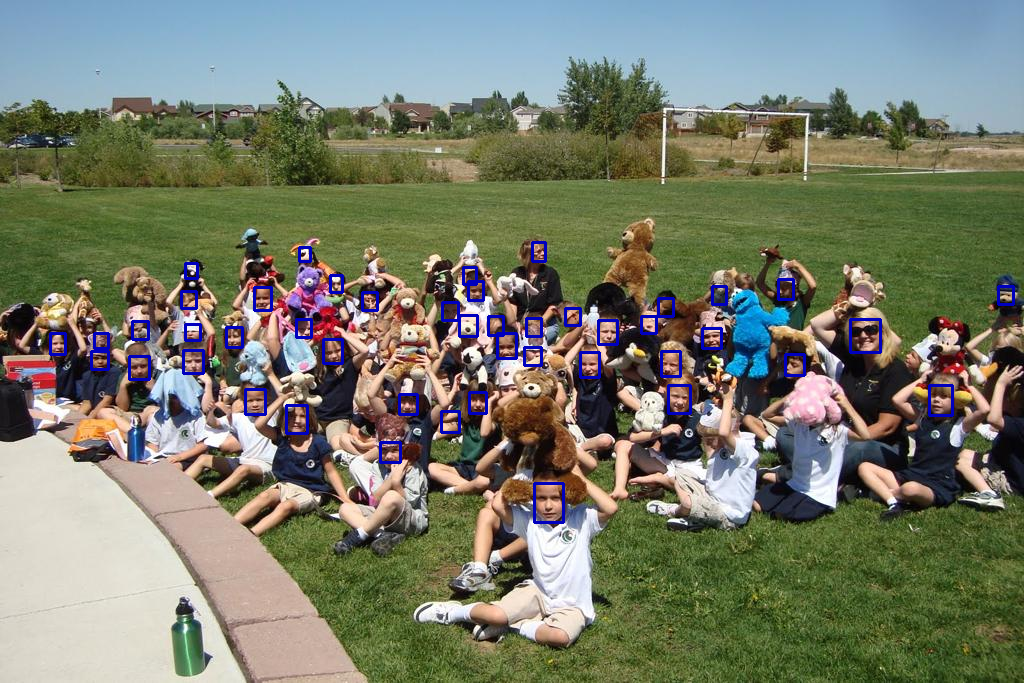

In [6]:
import cv2
import face_detection
import time
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

load

im = cv2.imread("/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test/images/22--Picnic/22_Picnic_Picnic_22_106.jpg")
start = time.time()
detections = detector.detect(im)
for rectangle in detections:
  i = cv2.rectangle(im, (int(rectangle[0]), int(rectangle[1])), (int(rectangle[2]), int(rectangle[3])), (190,0,0), 2)
print("time: ", (time.time() - start))
from google.colab.patches import cv2_imshow
cv2_imshow(i)

**SRN**

**RetinaFace**

In [7]:
!pip install retinaface-pytorch

     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 7.5MB 9.1MB/s 
     |████████████████████████████████| 2.1MB 57.7MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 112kB 58.8MB/s 
     |████████████████████████████████| 163kB 51.1MB/s 
     |████████████████████████████████| 4.6MB 51.3MB/s 
     |████████████████████████████████| 634kB 70.8MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 122kB 67.2MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13448 sha256=ab32282e4c655183ab47e30272c62729a15c8ebf756afe39e8d3e49c6a24f0b3
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=ff1aa9246aefe7c785e667366aebf9e07d4d7481180cfa5ae6f976809155a61c
  Stored in directory: /root/.cache/

Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_2020-07-20-f168fae3c.zip


/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


time:  9.673728466033936


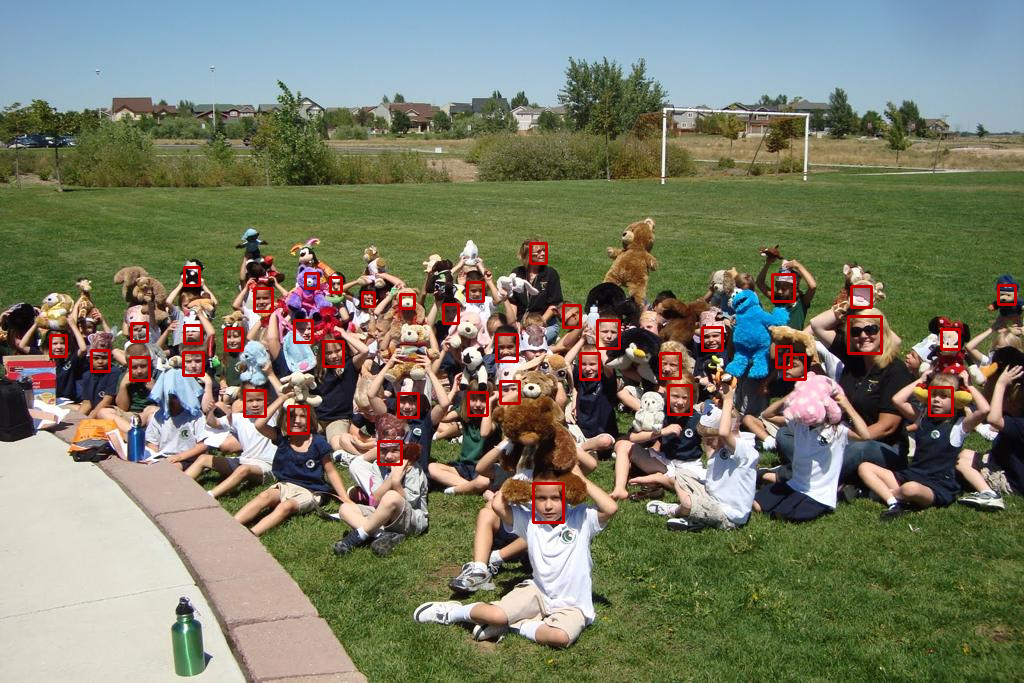

In [8]:
import cv2
from retinaface.pre_trained_models import get_model

model = get_model("resnet50_2020-07-20", max_size=2048)
model.eval()
start = time.time()
im = cv2.imread("/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test/images/22--Picnic/22_Picnic_Picnic_22_106.jpg")
detections = model.predict_jsons(im, confidence_threshold=.5, nms_threshold=0.3)
print("time: ", time.time() - start)
for rect in detections:
  rectangle = rect['bbox']
  i = cv2.rectangle(im, (int(rectangle[0]), int(rectangle[1])), (int(rectangle[2]), int(rectangle[3])), (0,0,190), 2)
cv2_imshow(i)